In [46]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
# from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
from pydoc import help
# from pyhdf.SD import *
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [47]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)

In [48]:
#in ctp&hilow
with open('soundings_ctp_hilow.pkl', 'rb') as file:
    
    soundings = pickle.load(file)

soundings.shape

(2626, 13)

In [49]:
#in fig 2&3 soil redo
with open('fwi_after_changes.pkl','rb') as file:
    
    fwidf = pickle.load(file)

fwidf.shape

(2834, 1)

In [50]:
#in gaoyun_precip

with open('gpdf.pdkl','rb') as file:
    
    pdf = pickle.load(file)

pdf.shape

(2718, 7)

In [51]:
resultdf = soundings.join(pdf, how='inner').join(fwidf, how='inner')

resultdf.index = pd.to_datetime(resultdf.index)

resultdf.shape

(2384, 21)

In [31]:
# resultdf = resultdf[~resultdf.index.isin(cloudmask)]

# resultdf.shape

In [52]:
apesdf = resultdf[resultdf['APE'] == True]

print("total ape count: ", "mine:", (apesdf.shape[0]/resultdf.shape[0])*100, "gloria's:", (368/2172)*100)

print("")

print(apesdf.shape[0])

total ape count:  mine: 18.20469798657718 gloria's: 16.94290976058932

434


In [58]:
resultdf['date'] = resultdf.index

resultdf['month'] = resultdf.index.month

resultdf['day'] = resultdf.index.day

# contains lists of CTP for every month-day

ctpdf = resultdf.groupby(['month', 'day'])['ctp'].agg(list).reset_index()

ctpdf['ctpz']= ""

for i in range(ctpdf.shape[0]):
    
    # extracts all CTPs for the month-day 
    
    x = np.array(ctpdf['ctp'][i])

    x = x.reshape(-1, 1)

    qt = QuantileTransformer(output_distribution='normal')
    
    xqt = qt.fit_transform(x)
    
    ctpdf['ctpz'][i] = xqt
    
#output of xqt puts every value in a list, this removes the inner lists

ctpdf['ctpz'] = ctpdf['ctpz'].apply(lambda x: [item for sublist in x for item in sublist])  

ctp_raw = ctpdf.explode('ctp').drop('ctpz',axis=1)

ctp_z = ctpdf.explode('ctpz').drop('ctp',axis=1)

ctpz = ctp_z['ctpz']

ctpdf = pd.concat([ctp_raw, ctpz], axis=1)

resultdf = resultdf.reset_index()

ctpdf = ctpdf.reset_index()

resultdf = pd.merge(resultdf, ctpdf[['month','day', 'ctp', 'ctpz']], on=['month', 'day', 'ctp'], how='left')

In [34]:
hilowdf = resultdf.groupby(['month', 'day'])['hilow'].agg(list).reset_index()

hilowdf = hilowdf.rename(columns={'hilow': 'hilow'})

hilowdf['hilowz']=""

for i in range(hilowdf.shape[0]):
    
    x = np.array(hilowdf['hilow'][i])

    x = x.reshape(-1, 1)

    qt = QuantileTransformer(output_distribution='normal')

    xqt = qt.fit_transform(x)
    
    hilowdf['hilowz'][i] = xqt
    
hilowdf['hilowz'] = hilowdf['hilowz'].apply(lambda x: [item for sublist in x for item in sublist])  

hilow_raw = hilowdf.explode('hilow').drop('hilowz',axis=1)

hilow_z = hilowdf.explode('hilowz').drop('hilow',axis=1)

hilowz = hilow_z['hilowz']

hilowdf = pd.concat([hilow_raw, hilowz], axis=1)

resultdf = pd.merge(resultdf, hilowdf[['month', 'day', 'hilow', 'hilowz']], on=['month', 'day', 'hilow'], how='left')

resultdf = resultdf.set_index('date')

resultdf.drop('index', axis=1, inplace=True)

In [35]:
#dry coupling: positive CTP anomaly AND FWI < 0.4, wet coupling: negative HI_low anomaly AND FWI > 0.7

resultdf['dry_coupling'] = (resultdf['ctpz'] > 0) & (resultdf['fwi'] < 0.4)

resultdf['wet_coupling'] = (resultdf['hilowz'] < 0) & (resultdf['fwi'] > 0.7)

In [36]:
# gloria APE information 

ape_cases = xr.open_dataset("APEs_time_data.nc")

ape_cases_date = pd.to_datetime(ape_cases['time'], unit='D', origin='1970-01-01')

ape_cases_type = ape_cases['LAC_idx']

ape_cases_df = pd.DataFrame({
    
    'date': ape_cases_date,
    
    'type': ape_cases_type
})

ape_cases_df = ape_cases_df.set_index("date")

ape_cases_df['type'] = ape_cases_df['type'].replace({0: 'dry_coupling', 1: 'wet_coupling', 2: 'neither'})

ape_cases_df['dry_coupling'] = ape_cases_df['type'] == 'dry_coupling'

ape_cases_df['wet_coupling'] = ape_cases_df['type'] == 'wet_coupling'

ape_cases_df['APE'] = True

ape_cases_df = ape_cases_df.drop('type', axis=1)

In [37]:
annie_ape_info = resultdf[['APE','dry_coupling','wet_coupling']]

gloria_ape_info = ape_cases_df

comb = pd.merge(
    
    annie_ape_info,
    
    gloria_ape_info,
    
    left_index=True,
    
    right_index=True,
    
    how='left'
)

comb['APE'] = comb['APE_y'].fillna(False)

comb['dry_coupling'] = np.where(comb['dry_coupling_y'].notna(), comb['dry_coupling_y'], comb['dry_coupling_x'])

comb['wet_coupling'] = np.where(comb['wet_coupling_y'].notna(), comb['wet_coupling_y'], comb['wet_coupling_x'])

comb = comb[['APE','dry_coupling','wet_coupling']]

resultdf = resultdf.drop(columns={'APE','dry_coupling','wet_coupling'})

resultdf = pd.merge(resultdf, comb, left_index=True, right_index=True, how='inner')

In [38]:
drydf = resultdf[resultdf['dry_coupling'] == True]

drydf = drydf[['interp_temp','q_obs','interp_rh','APE']]

wetdf = resultdf[resultdf['wet_coupling'] == True]

wetdf = wetdf[['interp_temp','q_obs','interp_rh','APE','interp_alt']]

print("dry:",drydf.shape[0]/resultdf.shape[0],"wet:",wetdf.shape[0]/resultdf.shape[0])

#should be about equal and around 17%

dry: 0.17659395973154363 wet: 0.1723993288590604


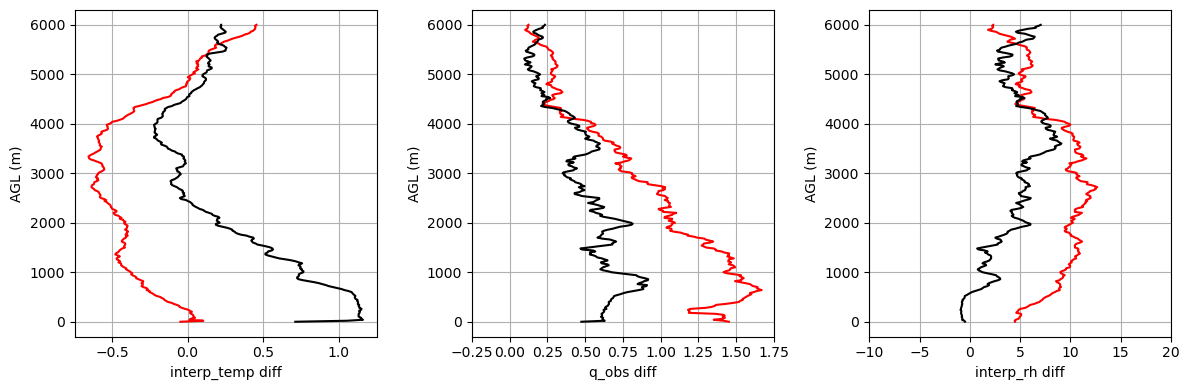

In [39]:
def composite_profile(arrays):
    
    return np.nanmean(arrays.tolist(), axis=0)

fig2vars = ['interp_temp', 'q_obs', 'interp_rh']

y = resultdf['interp_alt'][0]

y = y[0:301]

num_cols = len(fig2vars)

fig, axs = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

for i, var in enumerate(fig2vars):
    
    drytrue = composite_profile(drydf[drydf['APE'] == True][var])
    
    dryfalse = composite_profile(drydf[drydf['APE'] == False][var])
    
    wettrue = composite_profile(wetdf[wetdf['APE'] == True][var])
    
    wetfalse = composite_profile(wetdf[wetdf['APE'] == False][var])

    xdry = drytrue - dryfalse
    
    xdry = xdry[0:301]
    
    xwet = wettrue - wetfalse
    
    xwet = xwet[0:301]
    
    if var == 'interp_temp':
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
#         axs[i].set_xlim(-1.25, 1.0)
#         ticks = np.arange(-1, 1.5, 0.5)
#         axs[i].set_xticks(ticks)

        
    elif var == 'q_obs':
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
        axs[i].set_xlim(0, 1.5)
        ticks = np.arange(-0.25, 2, 0.25)
        axs[i].set_xticks(ticks)
        
    else:
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
        axs[i].set_xlim(-10, 20)
        ticks = np.arange(-10, 25, 5)
        axs[i].set_xticks(ticks)

plt.tight_layout()

plt.show()


Satisfied, though more so between 1 and 3.5 km:
-For dry coupling regimes, the increases of q and RH in the PBL and the LT associated with APEs are also stronger than those with the non-APEs, especially between 0.5 km and 3.5 km AGL, and the contrast between APEs and non-APEs in dry-coupling regime is larger than that for wet-coupling regimes.

Satisfied:
-Notice that the greatest contrast between RH of APEs and that of non-APEs occurs between 1 km and 3.5 km AGL (above the PBL), which is the combined result of high q and decreasing T over this layer, highlighting the possible strong influence of LT humidity on deep convection

Not satisfied, sign of temperature difference is the same -- both positive, ie average temperature for APEs is higher in both cases 
-In contrast, the sign of the temperature difference between APEs and non-APEs below 1.7 km AGL varies between
the dry-coupling and wet-coupling regimes. For the dry-coupling regimes, the average temperature of APEs is lower
than that of the non-APEs (This is presumably due to the stronger surface sensible flux and less stable atmosphere (a steep lapse rate or faster decrease of temperature with height) associated with APEs than the non-APEs under the dry coupling regime)

Not totally satisfied, average temp of APEs for wet-coupling always warmer 
-For the wet-coupling regime, the average temperature of the APEs is warmer than that of the nonAPEs below 1.7 km AGL. This is consistent with a weaker lapse rate associated with a more humid environment, presumably due to vertical mixing of shallow convection, in the APEs than in the non-APEs cases.

Not satisfied:
-Above 1.7 km AGL, temperature of the APEs cases is lower than that of the non-APEs for both dry and wet-coupling regimes, as expected from less stable thermodynamic conditions in the APEs than in the non-APEs.


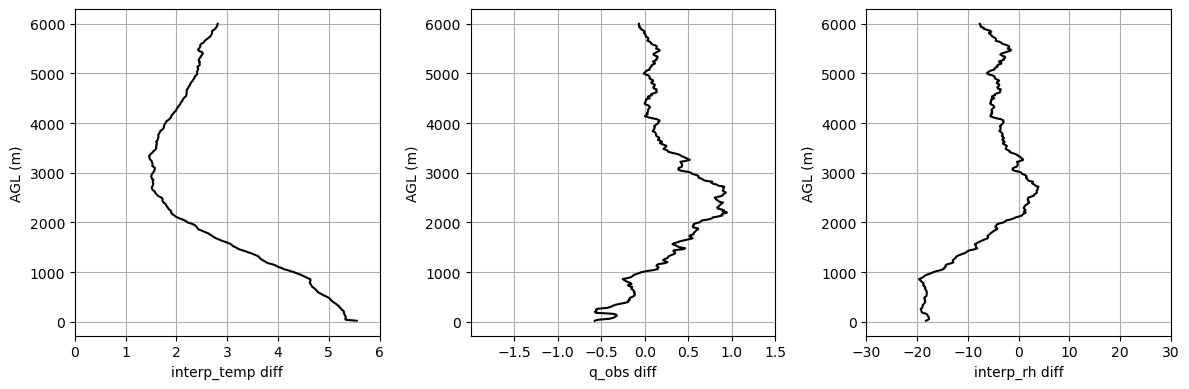

In [40]:
#figure 3 construction

apesdf = resultdf[resultdf['APE'] == True]

fig3vars = ['interp_temp', 'q_obs', 'interp_rh']

y = resultdf['interp_alt'][0]

y = y[1:301]

num_cols = len(fig3vars)

fig, axs = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

for i, var in enumerate(fig3vars):
    
    dry = composite_profile(apesdf[apesdf['dry_coupling'] == True][var])
    
    wet = composite_profile(apesdf[apesdf['wet_coupling'] == True][var]) 
    
    diff = dry - wet
    
    #truncate to only 6000 km AGL
    diff = diff[1:301]
    
    if var == 'interp_temp':
        
        axs[i].set_xlim(0, 6)
        ticks = np.arange(0, 7, 1)
        axs[i].set_xticks(ticks)
   
    elif var == 'q_obs':
        
        axs[i].set_xlim(-2, 1)
        ticks = np.arange(-1.5, 2, 0.5)
        axs[i].set_xticks(ticks)
    
    else: 
        
        axs[i].set_xlim(-30, 30)
        ticks = np.arange(-30, 40, 10)
        axs[i].set_xticks(ticks)
    
    axs[i].plot(diff, y, color='black')
    axs[i].set_xlabel(f'{var} diff')
    axs[i].set_ylabel('AGL (m)')
    axs[i].grid()

plt.tight_layout()

plt.show()

Satisfied: 
-In general, T is higher for APEs under dry-coupling than under wet-coupling regime (Figure 3a), especially in the PBL (below 2 km)

Satisfied, though transition from negative --> positive occurs around 1.5km AGL rather than 1km AGL: 
-Notably, there is a significant difference in LT specific humidity between dry- and wet-coupling regimes (Figure 3b), with q associated with APEs being slightly lower below 1 km AGL under dry-coupling than under wetcoupling regime, but higher above 1 km, especially between 2 km and 3 km AGL. This suggests that APEs require
entrainment of higher LT moisture under dry-coupling than under wet-coupling regimes. 

Satisfied: 
-3b suggests that higher LT specific humidity is needed for APEs under the dry-coupling than under the wet-coupling
regimes. 

Satisfied, though RH lower until 2km AGL:
-Moreover, RH associated with dry-coupling regimes is less than that of wet-coupling regimes in the PBL (Figure 3c), as expected from a drier PBL over a dry surface.

Satisfied: 
-However, such an RH difference becomes smaller and eventually disappears in the LT (2-4 km). This is because the lower RH in the dry-coupling regimes is mainly due to warmer T below 2 km AGL (Figure 3b), whereas above 2 km AGL, the higher q and slightly warmer T in the drycoupling regimes balance each other out and lead to a similar RH as in the wet-coupling regimes 

In [17]:
wetapes = apesdf[apesdf['wet_coupling'] == True]

wetapes = wetapes.reset_index()

precip = []

for i in range(wetapes.shape[0]):
    
    p = wetapes['afternoon'][i]
    
    precip.append(p)
    
print(np.mean(precip))

wetapes.shape

4.101952519852203


(78, 28)

In [18]:
dryapes = apesdf[apesdf['dry_coupling'] == True]

dryapes = dryapes.reset_index()

precip_dry = []

for i in range(dryapes.shape[0]):
    
    p = dryapes['afternoon'][i]
    
    precip_dry.append(p)

print(np.mean(precip_dry))

dryapes.shape

2.013290726397965


(91, 28)

- In general, T is higher for APEs under dry-coupling than under wet-coupling regime (Figure 3a) especially in the PBL (below 2 km). This can be attributed to stronger sensible heat flux and temperature mixing over a dry surface. 

- Notably, there is a significant difference in LT specific humidity between dry- and wet-coupling regimes (Figure 3b), with q associated with APEs being slightly lower below 1 km AGL under dry-coupling than under wetcoupling regime, but higher above 1 km, especially between 2 km and 3 km AGL. This suggests that APEs require entrainment of higher LT moisture under dry-coupling than under wet-coupling regimes. 

- Both Figures 2b and 3b suggest that higher LT specific humidity is needed for APEs under the dry-coupling than under the wet-coupling regimes. Moreover, RH associated with dry-coupling regimes is less than that of wet-coupling regimes in the PBL (Figure 3c), as expected from a drier PBL over a dry surface. However, such an RH difference becomes smaller and eventually disappears in the LT (2-4 km). This is because the lower RH in the dry-coupling regimes is mainly due to warmer T below 2 km AGL (Figure 3b), whereas above 2 km AGL, the higher q and slightly warmer T in the drycoupling regimes balance each other out and lead to a similar RH as in the wet-coupling regimes. 

In [24]:
#apes comparison to gaoyuns
#conclusion is that APE proportion not too far off
#but dry/wet categorization not as even as they should be 


apesdf = resultdf[resultdf['APE'] == True]

print("total ape count: ", "mine:", (apesdf.shape[0]/resultdf.shape[0])*100, "gloria's:", (368/2172)*100)
print("")

apesdry = apesdf[apesdf['dry_coupling'] == True]

apeswet = apesdf[apesdf['wet_coupling'] == True]

print("total dry coupling cases: ", "mine:", (drydf.shape[0]/resultdf.shape[0])*100, "gloria's:", (388/2172)*100)
print("")
print("total wet coupling cases: ", "mine:", (wetdf.shape[0]/resultdf.shape[0])*100, "gloria's:", (389/2172)*100)
print("")
print("dry coupling apes count: ", "mine:", (apesdry.shape[0]/drydf.shape[0])*100, "gloria's:", (94/388)*100)
print("")
print("wet coupling apes count: ", "mine:", (apeswet.shape[0]/wetdf.shape[0])*100, "gloria's:", (79/389)*100)
print("")

total ape count:  mine: 14.38758389261745 gloria's: 16.94290976058932

total dry coupling cases:  mine: 17.659395973154364 gloria's: 17.863720073664823

total wet coupling cases:  mine: 17.23993288590604 gloria's: 17.909760589318598

dry coupling apes count:  mine: 21.61520190023753 gloria's: 24.22680412371134

wet coupling apes count:  mine: 18.97810218978102 gloria's: 20.308483290488432



In [41]:
with open('soundings_fig2&3.pdkl', 'wb') as file:
    
    pickle.dump(resultdf, file)

In [20]:
len(apesdry.index), len(apeswet.index)

(91, 78)

In [21]:
len(apesdf.index)

343